
# Qiskit Aer: Simulators

---








In [1]:
from qiskit import IBMQ
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

Now we will show how to import the Qiskit Aer simulator backend and use it to run ideal (noise free) Qiskit Terra circuits.

In [3]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

The Aer provider contains a variety of high performance simulator backends for a variety of simulation methods. The available backends on the current system can be viewed using ``Aer.backends``

In [4]:
Aer.backends()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

The main simulator backend of the Aer provider is the ``AerSimulator`` backend. A new simulator backend can be created using ``Aer.get_backend('aer_simulator')``.

In [5]:
simulator = Aer.get_backend('aer_simulator')

The default behavior of the ``AerSimulator`` backend is to mimic the execution of an actual device. If a ``QuantumCircuit`` containing measurements is run it will return a count dictionary containing the final values of any classical registers in the circuit. The circuit may contain gates, measurements, resets, conditionals, and other custom simulator instructions 

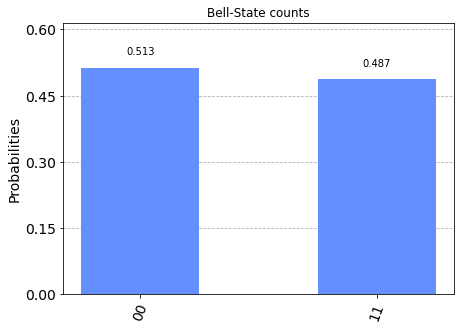

In [6]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
#simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [7]:
# Run and get memory (measurement outcomes for each individual shot)
result = simulator.run(circ, shots=10, memory=True).result()
memory = result.get_memory(circ)
print(memory)

['00', '11', '11', '00', '00', '11', '00', '00', '00', '11']


##### Simulation methods

The AerSimulator supports a variety of simulation methods, each of which supports a different set of instructions. The method can be set manually using ``simulator.set_option(method=value)`` option, or a simulator backend with a preconfigured method can be obtained directly from the Aer provider using ``Aer.get_backend``.

When simulating ideal circuits, changing the method between the exact simulation methods stabilizer, ``statevector``, ``density_matrix`` and ``matrix_product_state`` should not change the simulation result (other than usual variations from sampling probabilities for measurement outcomes)

Each of these methods determines the internal representation of the quantum circuit and the algorithms used to process the quantum operations. They each have advantages and disadvantages, and choosing the best method is a matter of investigation. 

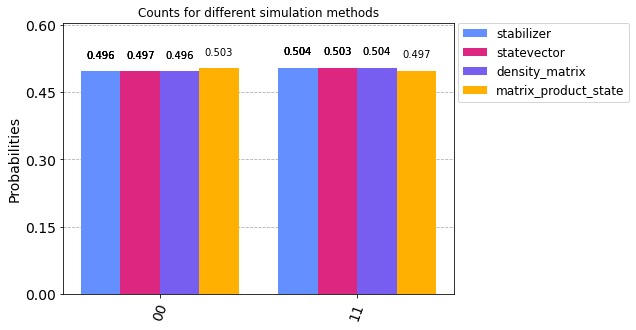

In [8]:
# Increase shots to reduce sampling variance
shots = 10000

# Stabilizer simulation method
sim_stabilizer = Aer.get_backend('aer_simulator_stabilizer')
job_stabilizer = sim_stabilizer.run(circ, shots=shots)
counts_stabilizer = job_stabilizer.result().get_counts(0)

# Statevector simulation method
sim_statevector = Aer.get_backend('aer_simulator_statevector')
job_statevector = sim_statevector.run(circ, shots=shots)
counts_statevector = job_statevector.result().get_counts(0)

# Density Matrix simulation method
sim_density = Aer.get_backend('aer_simulator_density_matrix')
job_density = sim_density.run(circ, shots=shots)
counts_density = job_density.result().get_counts(0)

# Matrix Product State simulation method
sim_mps = Aer.get_backend('aer_simulator_matrix_product_state')
job_mps = sim_mps.run(circ, shots=shots)
counts_mps = job_mps.result().get_counts(0)

plot_histogram([counts_stabilizer, counts_statevector, counts_density, counts_mps],
               title='Counts for different simulation methods',
               legend=['stabilizer', 'statevector',
                       'density_matrix', 'matrix_product_state'])

The default simulation method is automatic which will automatically select a one of the other simulation methods for each circuit based on the instructions in those circuits. A fixed simulation method can be specified by by adding the method name when getting the backend, or by setting the method option on the backend.

##### GPU simulation

The statevector, density_matrix and unitary simulators support running on a NVidia GPUs. For these methods the simulation device can also be manually set to CPU or GPU using ``simulator.set_options(device='GPU')`` backend option. If a GPU device is not available setting this option will raise an exception.

In [11]:
from qiskit.providers.aer import AerError

# Initialize a GPU backend
# Note that the cloud instance for tutorials does not have a GPU
# so this will raise an exception.
try:
    simulator_gpu = Aer.get_backend('aer_simulator')
    simulator_gpu.set_options(device='GPU')
except AerError as e:
    print(e)

The Aer provider will also contain preconfigured GPU simulator backends if Qiskit Aer was installed with GPU support on a compatible system:

* ``aer_simulator_statevector_gpu``
* ``aer_simulator_density_matrix_gpu``
* ``aer_simulator_unitary_gpu``

Note: The GPU version of Aer can be installed using ``pip install qiskit-aer-gpu``.

##### Simulation precision

One of the available simulator options allows setting the float precision for the statevector, density_matrix unitary and superop methods. This is done using the ``set_precision="single"`` or ``precision="double" `` (default) option:

In [9]:
# Configure a single-precision statevector simulator backend
simulator = Aer.get_backend('aer_simulator_statevector')
simulator.set_options(precision='single')

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
print(counts)

{'00': 523, '11': 501}


Setting the simulation precision applies to both CPU and GPU simulation devices. Single precision will halve the required memory and may provide performance improvements on certain systems.

##### Can we simulate noise?

##### Device backend noise model simulations

We will now show how to use the Qiskit Aer noise module to automatically generate a basic noise model for an IBMQ hardware device, and use this model to do noisy simulations of QuantumCircuits to study the effects of errors which occur on real devices.

Note, that these automatic models are only an approximation of the real errors that occur on actual devices, due to the fact that they must be build from a limited set of input parameters related to average error rates on gates. The study of quantum errors on real devices is an active area of research and we discuss the Qiskit Aer tools for configuring more detailed noise models in another notebook.

In [10]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

The Qiskit Aer device noise model automatically generates a simplified noise model for a real device. This model is generated using the calibration information reported in the ``BackendProperties`` of a device and takes into account

* The gate_error probability of each basis gate on each qubit.
* The gate_length of each basis gate on each qubit.
* The T1, T2 relaxation time constants of each qubit.
* The readout error probability of each qubit.

We will use real noise data for an IBM Quantum device using the data stored in Qiskit Terra. Specifically, in this tutorial, the device is ``ibmq_vigo```.

In [11]:
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

Now we construct a test circuit to compare the output of the real device with the noisy output simulated on the Qiskit Aer AerSimulator. Before running with noise or on the device we show the ideal expected output with no noise.

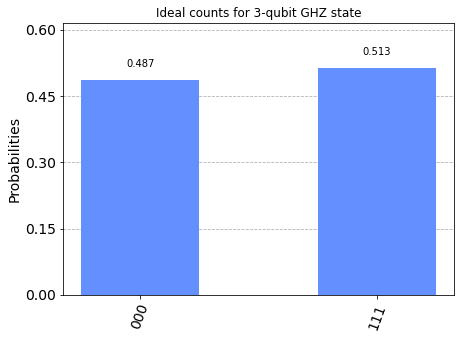

In [12]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circ, sim_ideal)).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

How to generate a simulator that mimics a device?


We call ``from_backend`` to create a simulator for ``ibmq_vigo``

In [13]:
sim_vigo = AerSimulator.from_backend(device_backend)

By storing the device properties in ``vigo_simulator``, we ensure that the appropriate basis gates and coupling map are used when compiling circuits for simulation, thereby most closely mimicking the gates that will be executed on a real device. In addition ``vigo_simulator`` contains an approximate noise model consisting of:

* Single-qubit gate errors consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.
* Two-qubit gate errors consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.
* Single-qubit readout errors on the classical bit value obtained from measurements on individual qubits.

For the gate errors the error parameter of the thermal relaxation errors is derived using the ``thermal_relaxation_error`` function from ``aer.noise.errors module``, along with the individual qubit T1 and T2 parameters, and the ``gate_time`` parameter from the device backend properties. The probability of the depolarizing error is then set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxation is equal to the ``gate_error`` value from the backend properties.

For the readout errors the probability that the recorded classical bit value will be flipped from the true outcome after a measurement is given by the qubit ``readout_errors``.

Once we have created a noisy simulator backend based on a real device we can use it to run noisy simulations.

Important: When running noisy simulations it is critical to transpile the circuit for the backend so that the circuit is transpiled to the correct noisy basis gate set for the backend.

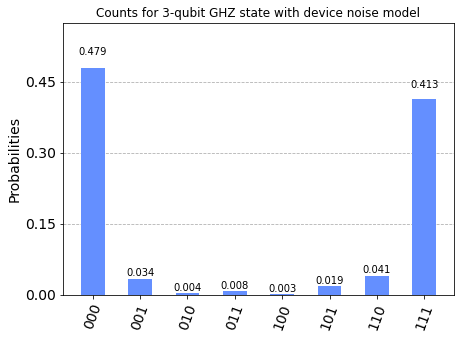

In [14]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")

In [18]:
data_noise=result_noise.data()

In [19]:
data_noise

{'counts': {'0x2': 7,
  '0x3': 15,
  '0x7': 470,
  '0x0': 438,
  '0x6': 43,
  '0x4': 5,
  '0x1': 32,
  '0x5': 14}}

You may also be interested in:
* Building Noise Models https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html

* Applying noise to custom unitary gates https://qiskit.org/documentation/tutorials/simulators/4_custom_gate_noise.html

In [20]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright